# Bank Customer Segmentation Model

## Import Modules and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from dateutil.relativedelta import relativedelta
from datetime import date   
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/dp846/OneDrive/Documents/bank_transactions.csv")

## Exploratory Data Analysis

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

There are a good number of null values in the dataset. This can be resolved by simply dropping these values from the dataset.

In [6]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [7]:
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [8]:
df.nunique()

TransactionID              1041614
CustomerID                  879358
CustomerDOB                  17233
CustGender                       3
CustLocation                  9275
CustAccountBalance          160723
TransactionDate                 55
TransactionTime              81855
TransactionAmount (INR)      92391
dtype: int64

Seeing that there are 3 unique values in the CustGender column, some further analysis needs to be made to determine whether or not this third gender needs to remain in the dataset.

In [9]:
df['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [10]:
df.loc[df['CustGender'] == 'T']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
953529,T959988,C3380368,1/1/1800,T,CHENNAI,50050.0,10/9/16,170731,32500.0


There is only one row in the dataset with T as the CustGender value. There is no need to keep this row in the dataset. 

In [11]:
df.drop(df[df['CustGender'] == 'T'].index, inplace = True)
df.reset_index(drop=True, inplace=True)

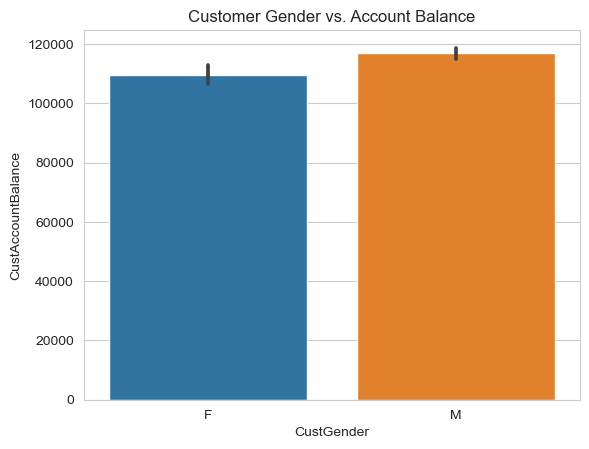

In [12]:
sns.barplot(data=df,x='CustGender',y='CustAccountBalance').set(title='Customer Gender vs. Account Balance');

This barplot demonstrates that the male customers' average account balance seems to be higher than the female customers'. 

In [13]:
df = pd.get_dummies(df,columns=['CustGender'],drop_first=True)

In this dataset, the CustGender column has binary non-numeric values (M or F). To represent the gender of the individual customer as a numerical value 0 or 1, dummy variables need to be created.

In [14]:
date_of_birth = {'customer_dob':[str(i).split('/') for i in df['CustomerDOB']]}
DOB = pd.DataFrame(date_of_birth)
DOB

,customer_dob
0,"[10, 1, 94]"
1,"[4, 4, 57]"
2,"[26, 11, 96]"
3,"[14, 9, 73]"
4,"[24, 3, 88]"
...,...
1041608,"[8, 4, 90]"
1041609,"[20, 2, 92]"
1041610,"[18, 5, 89]"
1041611,"[30, 8, 78]"


In [15]:
day_of_birth = {'customer_day_birth':[DOB.iloc[i]['customer_dob'][0] for i in tqdm(range(len(DOB)))]}
birth_day = pd.DataFrame(day_of_birth)

month_of_birth = {'customer_month_birth':[DOB.iloc[i]['customer_dob'][1] for i in tqdm(range(len(DOB)))]}
birth_month = pd.DataFrame(month_of_birth)

year_of_birth = {'customer_year_birth':[DOB.iloc[i]['customer_dob'][2] for i in tqdm(range(len(DOB)))]}
birth_year = pd.DataFrame(year_of_birth)

100%|██████████| 1041613/1041613 [01:03<00:00, 16435.51it/s]


The DOB dataframe was made to create a list consisting of the day, month, and year for each row. After creating the DOB dataframe, multiple for loops were used to separate the the day, month, and year and place them in their own dataframe.

In [16]:
birth_year['customer_year_birth'].unique()

array(['94', '57', '96', '73', '88', '72', '92', '82', '84', '78', '68',
       '1800', '89', '91', '85', '93', '86', '67', '79', '77', '97', '83',
       '90', '80', '81', '66', '87', '75', '95', '74', '71', '32', '59',
       '99', '65', '41', '54', '70', '76', '21', '69', '04', '43', '98',
       '51', '60', '56', '53', '47', '00', '64', '48', '62', '52', '55',
       '61', '36', '63', '42', '44', '38', '49', '58', '50', '46', '02',
       '45', '37', '07', '01', '39', '40', '13', '03', '05', '10', '11',
       '33', '34', '27', '19', '28', '30', '09', '31', '29', '35', '15',
       '16', '06', '08', '12', '23', '26', '24', '22', '14', '20', '25',
       '18'], dtype=object)

By looking at the unique customer birth years, it can be seen that the year 1800 seems to be out of place. To tackle this situation, it would be best to remove these customers from the dataset.

In [17]:
birth_year[birth_year['customer_year_birth']=='1800']

,customer_year_birth
16,1800
22,1800
28,1800
34,1800
150,1800
...,...
1041490,1800
1041499,1800
1041577,1800
1041579,1800


In [18]:
df['CustBirthDay'] = birth_day
df['CustBirthMonth'] = birth_month
df['CustBirthYear'] = birth_year

In [19]:
df.drop(df[df['CustBirthYear'] == '1800'].index, inplace = True)
df.reset_index(drop=True, inplace=True)

In [20]:
df['CustBirthYear'] = ['19' + i for i in df['CustBirthYear']]

After creating the new columns in the original dataframe and removing the rows of data with 1800 as the birth year, a for loop was used to add "19" in front of the values from the CustBirthYear column.

A similar process was then used when working with the transaction date.

In [21]:
transaction_date = {'trans_date':[str(i).split('/') for i in df['TransactionDate']]}
TD = pd.DataFrame(transaction_date)
TD

,trans_date
0,"[2, 8, 16]"
1,"[2, 8, 16]"
2,"[2, 8, 16]"
3,"[2, 8, 16]"
4,"[2, 8, 16]"
...,...
985317,"[18, 9, 16]"
985318,"[18, 9, 16]"
985319,"[18, 9, 16]"
985320,"[18, 9, 16]"


In [22]:
day_of_transaction = {'transaction_day':[TD.iloc[i]['trans_date'][0] for i in tqdm(range(len(TD)))]}
trans_day = pd.DataFrame(day_of_transaction)

month_of_transaction = {'transaction_month':[TD.iloc[i]['trans_date'][1] for i in tqdm(range(len(TD)))]}
trans_month = pd.DataFrame(month_of_transaction)

year_of_transaction = {'transaction_year':[TD.iloc[i]['trans_date'][2] for i in tqdm(range(len(TD)))]}
trans_year = pd.DataFrame(year_of_transaction)

100%|██████████| 985322/985322 [00:54<00:00, 18056.99it/s]


In [23]:
trans_year['transaction_year'].unique()

array(['16'], dtype=object)

In [24]:
df['TransactionDay'] = trans_day
df['TransactionMonth'] = trans_month
df['TransactionYear'] = trans_year

In [25]:
df['TransactionYear'] = ['20' + i for i in df['TransactionYear']]

Now that the day, month, and year columns have been created for the transaction and customer birth dates, the customer age can be calculated using relativedelta.

In [26]:
customer_age = []

for i in tqdm(range(len(df['TransactionDate']))):
    birthday = date(int(df['CustBirthYear'][i]),int(df['CustBirthMonth'][i]),int(df['CustBirthDay'][i]))
    transaction = date(int(df['TransactionYear'][i]),int(df['TransactionMonth'][i]),int(df['TransactionDay'][i]))
    cust_age = relativedelta(transaction, birthday).years
    customer_age.append(cust_age)
    
df['CustAge'] = customer_age

100%|██████████| 985322/985322 [00:47<00:00, 20788.97it/s]


In [27]:
df

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustGender_M,CustBirthDay,CustBirthMonth,CustBirthYear,TransactionDay,TransactionMonth,TransactionYear,CustAge
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0,10,1,1994,2,8,2016,22
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,2/8/16,141858,27999.0,1,4,4,1957,2,8,2016,59
2,T3,C4417068,26/11/96,MUMBAI,17874.44,2/8/16,142712,459.0,0,26,11,1996,2,8,2016,19
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2/8/16,142714,2060.0,0,14,9,1973,2,8,2016,42
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,0,24,3,1988,2,8,2016,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,8/4/90,NEW DELHI,7635.19,18/9/16,184824,799.0,1,8,4,1990,18,9,2016,26
985318,T1048564,C6459278,20/2/92,NASHIK,27311.42,18/9/16,183734,460.0,1,20,2,1992,18,9,2016,24
985319,T1048565,C6412354,18/5/89,HYDERABAD,221757.06,18/9/16,183313,770.0,1,18,5,1989,18,9,2016,27
985320,T1048566,C6420483,30/8/78,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0,1,30,8,1978,18,9,2016,38


In [28]:
df['CustAge'].value_counts()

26     73053
25     72905
24     68397
27     65386
28     61138
       ...  
100        6
92         3
90         2
91         1
98         1
Name: CustAge, Length: 98, dtype: int64

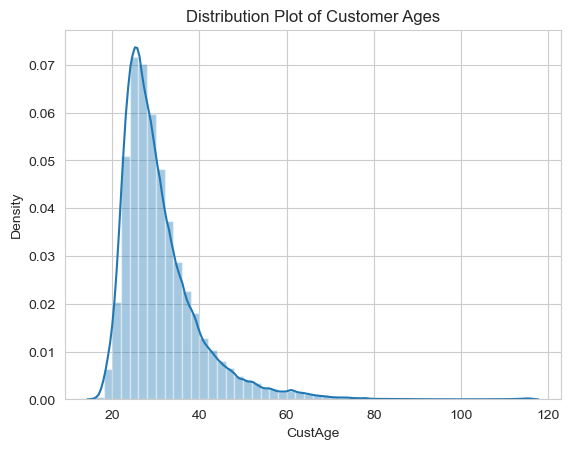

In [29]:
sns.distplot(df['CustAge']).set(title='Distribution Plot of Customer Ages');

The distribution plot of the customer ages demonstrates a right skewed distribution.

In [30]:
generations = []
for i in df['CustBirthYear']:
    if (int(i) > 2000):
        generation_a = 'After Google'
        generations.append(generation_a)
    elif (int(i) >= 1981 and int(i) <= 2000):
        generation_p = 'Progressives'
        generations.append(generation_p)
    elif (int(i) >= 1961 and int(i) <= 1980):
        generation_c = 'Conventionalists'
        generations.append(generation_c)
    else:
        generation_d = 'Die-Hards'
        generations.append(generation_d)

df['CustGeneration'] = generations
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustGender_M,CustBirthDay,CustBirthMonth,CustBirthYear,TransactionDay,TransactionMonth,TransactionYear,CustAge,CustGeneration
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,0,10,1,1994,2,8,2016,22,Progressives
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,2/8/16,141858,27999.0,1,4,4,1957,2,8,2016,59,Die-Hards
2,T3,C4417068,26/11/96,MUMBAI,17874.44,2/8/16,142712,459.0,0,26,11,1996,2,8,2016,19,Progressives
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2/8/16,142714,2060.0,0,14,9,1973,2,8,2016,42,Conventionalists
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,0,24,3,1988,2,8,2016,28,Progressives


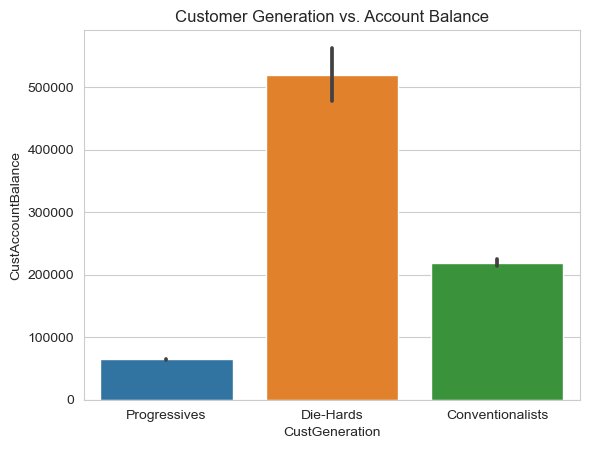

In [31]:
sns.barplot(data=df,x='CustGeneration',y='CustAccountBalance').set(title='Customer Generation vs. Account Balance');

Creating a categorical column to appropriately place the generation the customers belong to. The bar plot shows that the "Die-Hards" average account balance is higher than the other generations'.

In [32]:
df['TransactionDate'].unique()

array(['2/8/16', '1/8/16', '3/8/16', '5/8/16', '4/8/16', '6/8/16',
       '9/8/16', '8/8/16', '12/8/16', '7/8/16', '21/10/16', '16/10/16',
       '10/8/16', '14/8/16', '17/8/16', '21/8/16', '19/8/16', '24/8/16',
       '22/8/16', '29/8/16', '22/9/16', '23/9/16', '13/8/16', '25/8/16',
       '28/8/16', '15/8/16', '27/8/16', '31/8/16', '20/8/16', '23/8/16',
       '30/8/16', '11/8/16', '16/8/16', '26/8/16', '27/9/16', '18/8/16',
       '25/9/16', '26/9/16', '30/9/16', '3/9/16', '2/9/16', '1/9/16',
       '6/9/16', '5/9/16', '4/9/16', '9/9/16', '8/9/16', '7/9/16',
       '12/9/16', '11/9/16', '10/9/16', '15/9/16', '14/9/16', '13/9/16',
       '18/9/16'], dtype=object)

In [33]:
df.drop(['CustomerDOB', 'TransactionDate'], axis=1,inplace=True)

In [34]:
trans_date = []

for i in tqdm(range(len(df['TransactionID']))):
    t_date = date(int(df['TransactionYear'][i]),int(df['TransactionMonth'][i]),int(df['TransactionDay'][i]))
    trans_date.append(t_date)
    
df['TransactionDate'] = trans_date

100%|██████████| 985322/985322 [00:16<00:00, 60245.12it/s]


In [35]:
df.drop(['CustBirthDay', 'CustBirthMonth','CustBirthYear','TransactionDay','TransactionMonth','TransactionYear','TransactionID'], axis=1,inplace=True)

Created the TransactionDate column to improve the format of the date values. Once that was complete, there was no need to keep the CustBirthDay, CustBirthMonth, CustBirthYear, TransactionDay, TransactionMonth, TransactionYear, and TransactionID columns in the dataframe.

In [36]:
df

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-Hards,2016-08-02
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02
...,...,...,...,...,...,...,...,...,...
985317,C8020229,NEW DELHI,7635.19,184824,799.0,1,26,Progressives,2016-09-18
985318,C6459278,NASHIK,27311.42,183734,460.0,1,24,Progressives,2016-09-18
985319,C6412354,HYDERABAD,221757.06,183313,770.0,1,27,Progressives,2016-09-18
985320,C6420483,VISAKHAPATNAM,10117.87,184706,1000.0,1,38,Conventionalists,2016-09-18


In [37]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,985322.0,106061.188580,817905.353760,0.0,4582.1325,16006.3,53759.08,1.150355e+08
TransactionTime,985322.0,157434.409364,51270.673224,0.0,124242.0000,164625.0,200151.00,2.359590e+05
TransactionAmount (INR),985322.0,1452.425149,6139.765064,0.0,151.0000,431.0,1125.00,1.560035e+06
CustGender_M,985322.0,0.723067,0.447483,0.0,0.0000,1.0,1.00,1.000000e+00
CustAge,985322.0,30.780811,9.084187,16.0,25.0000,28.0,34.00,1.160000e+02


## Correlation Matrix

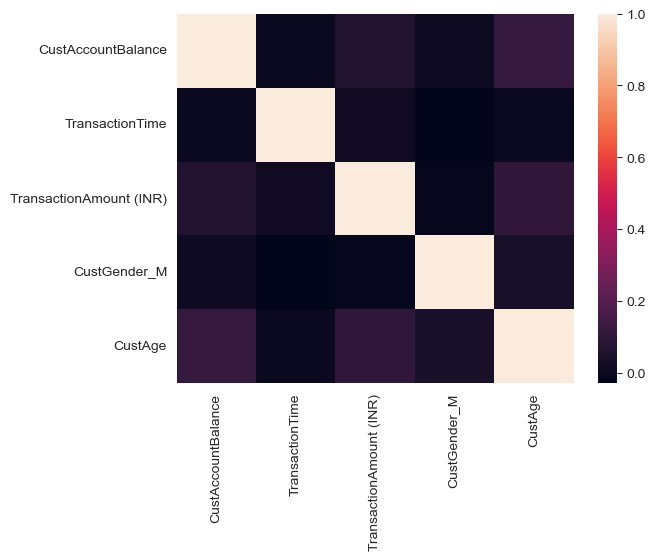

In [38]:
sns.heatmap(df.corr());

The correlation matrix shows that the correlations between "CustAccountBalance" and "TransactionAmount (INR)", "CustAccountBalance" and "CustAge", "TransactionAmount (INR)" and "CustAge" are weakly positively correlated. 

## Recency

To build the segmentation model, the customer's RFM profile would need to be derived. The customer's RFM profile consists of Recency, Frequency, and Monetary Value. In this case, the dataframe contains the Monetary Value (TransactionAmount (INR)), so it would not need to be calculated. 
<br>
<br>
Starting off with recency, it would need to be known when each customer was last seen making a transaction.

In [39]:
df['Rank'] = df.sort_values(['CustomerID','TransactionDate']).groupby(['CustomerID'])['TransactionDate'].rank(method='min').astype(int)

In [40]:
df_rec = df[df['Rank']==1]
df_rec.reset_index(drop=True, inplace=True)

In [41]:
df_rec

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02,1
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-Hards,2016-08-02,1
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02,1
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02,1
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02,1
...,...,...,...,...,...,...,...,...,...,...
841849,C5028150,PUNE,464.87,184632,3000.0,1,36,Conventionalists,2016-09-18,1
841850,C1034220,BANGALORE,1212.70,184734,1500.0,1,23,Progressives,2016-09-18,1
841851,C8020229,NEW DELHI,7635.19,184824,799.0,1,26,Progressives,2016-09-18,1
841852,C6459278,NASHIK,27311.42,183734,460.0,1,24,Progressives,2016-09-18,1


In [42]:
df_rec = df_rec.assign(Recency = (df_rec['TransactionDate'] - min(df_rec['TransactionDate'])))

In [43]:
df_rec['Recency'] = df_rec['Recency'].astype(str).str.replace(' days', '')

In [44]:
df_rec['Recency'] = df_rec['Recency'].astype(int)

In [45]:
df_rec.head()

,CustomerID,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank,Recency
0,C5841053,JAMSHEDPUR,17819.05,143207,25.0,0,22,Progressives,2016-08-02,1,1
1,C2142763,JHAJJAR,2270.69,141858,27999.0,1,59,Die-Hards,2016-08-02,1,1
2,C4417068,MUMBAI,17874.44,142712,459.0,0,19,Progressives,2016-08-02,1,1
3,C5342380,MUMBAI,866503.21,142714,2060.0,0,42,Conventionalists,2016-08-02,1,1
4,C9031234,NAVI MUMBAI,6714.43,181156,1762.5,0,28,Progressives,2016-08-02,1,1


## Frequency

The frequency demonstrates how many times each customer has made a transaction.

In [46]:
freq = df_rec.groupby('CustomerID')['TransactionDate'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','Frequency']

In [47]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')

In [48]:
rec_freq.head()

,CustomerID,Frequency,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),CustGender_M,CustAge,CustGeneration,TransactionDate,Rank,Recency
0,C1010011,1,NEW DELHI,120180.54,11229,356.0,1,33,Progressives,2016-08-09,1,8
1,C1010012,1,MUMBAI,24204.49,204409,1499.0,1,22,Progressives,2016-08-14,1,13
2,C1010014,1,MUMBAI,38377.14,154451,1205.0,0,24,Progressives,2016-08-01,1,0
3,C1010018,1,CHAMPARAN,496.18,170254,30.0,0,26,Progressives,2016-09-15,1,45
4,C1010024,1,KOLKATA,87058.65,141103,5000.0,1,51,Conventionalists,2016-08-18,1,17


## Final Dataframe

Now that recency and frequency has been calculated, the final dataframe can be created with the columns required to build the customer segmentation model. 

In [49]:
finaldf = rec_freq[['CustomerID','Recency','Frequency','TransactionAmount (INR)']]

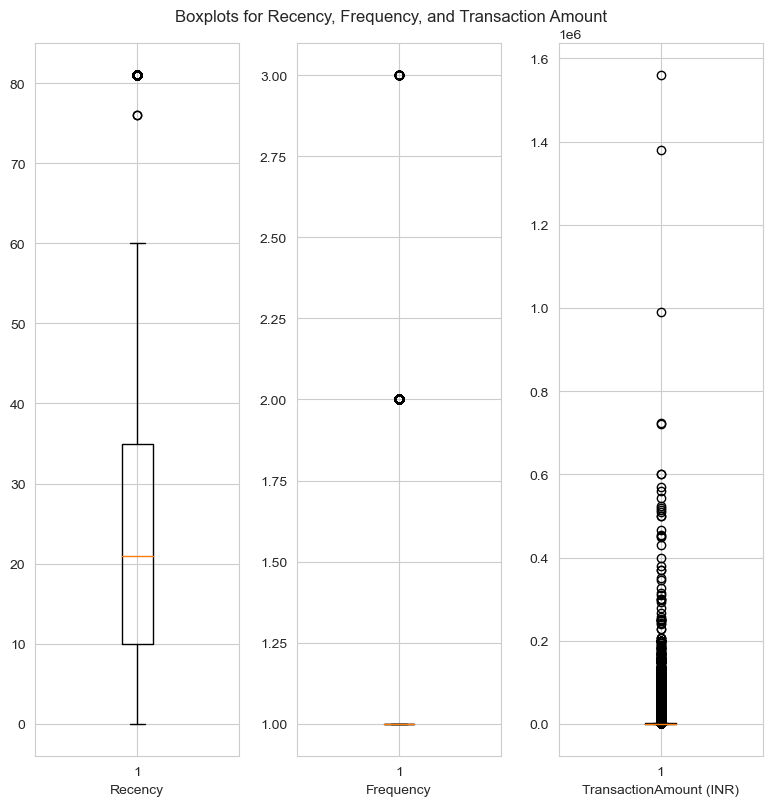

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8))
fig.suptitle('Boxplots for Recency, Frequency, and Transaction Amount')
fig.tight_layout()
ax1.boxplot(x=finaldf['Recency'])
ax1.set_xlabel('Recency')
ax2.boxplot(x=finaldf['Frequency'])
ax2.set_xlabel('Frequency')
ax3.boxplot(x=finaldf['TransactionAmount (INR)'])
ax3.set_xlabel('TransactionAmount (INR)');

The "Recency" and "Frequency" boxplots demonstrate that they are the two variables with a few visible outliers. The "TransactionAmount (INR)" variable has a good number of outliers. The outliers would need to be removed before building the segmentation model.

## Removing Outliers

To identify outliers, the z-score would have to be computed. In this case, the data points with a z-score greater than 3 would be removed.

In [51]:
new_df = finaldf[['Recency','Frequency','TransactionAmount (INR)']]
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [52]:
new_df.head()

,Recency,Frequency,TransactionAmount (INR)
0,8,1,356.0
1,13,1,1499.0
2,0,1,1205.0
3,45,1,30.0
4,17,1,5000.0


## Clustering

Now, it's time to apply standardization to the dataset's values so that they follow a normal distribution.

In [53]:
new_df = new_df.drop_duplicates()
colmns = ['Recency','Frequency','TransactionAmount (INR)']
features = new_df[colmns]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = colmns)
scaled_features.head()

,Recency,Frequency,TransactionAmount (INR)
0,-1.020457,0.0,-0.633509
1,-0.688984,0.0,-0.240614
2,-1.550813,0.0,-0.341674
3,1.432440,0.0,-0.745568
4,-0.423806,0.0,0.962820


## Creating and Fitting Kmeans Model

To create and fit multiple KMeans models, a for loop would be used to test 1 to 10 clusters. Once the Sum of Squares Errors for each K value have been listed, the "elbow" plot would help determine the optimal number of clusters to use. 

100%|██████████| 9/9 [00:35<00:00,  3.92s/it]


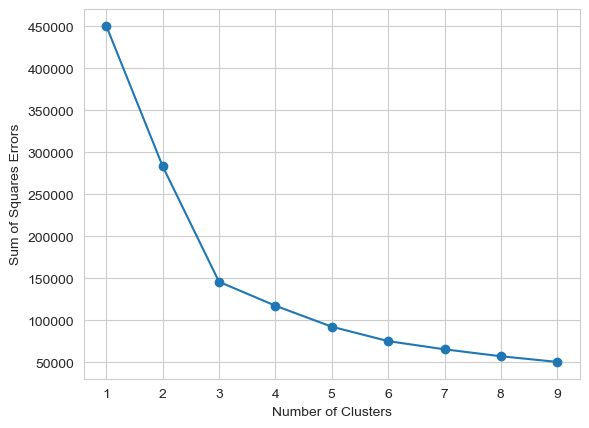

In [54]:
SSE = []
for k in tqdm(range(1,10)):
    model = KMeans(n_clusters = k, init='k-means++')
    model.fit(scaled_features)
    SSE.append(model.inertia_)

plt.plot(range(1,10), SSE, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Errors');

Based on this "elbow" plot, the point of inflection on the curve is at the 3-cluster mark. This means that the best number of clusters to use in this KMeans model is 3.

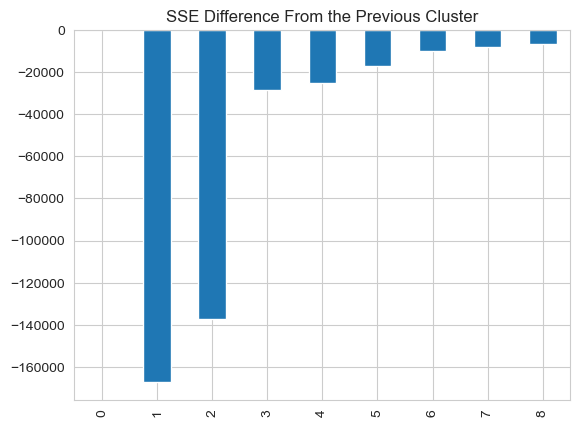

In [55]:
pd.Series(SSE).diff().plot(kind='bar', title='SSE Difference From the Previous Cluster');

In [56]:
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(scaled_features)

KMeans(n_clusters=3)

In [57]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.4925927480479703


To assess the performance of this KMeans model, the silhouette score was used. This is a metric that is used to calculate the goodness of a clustering technique. The coefficient value ranges from -1 to +1. A high silhouette score shows that the object is well matched to its own cluster and poorly matches to neighboring clusters.
<br>
The silhouette coefficient of this model is 0.49, indicating fair cluster separation.

Now that the segmentation model is built, the clusters need to be assigned to each customer in the dataset.

In [58]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred
frame.head()

,Recency,Frequency,TransactionAmount (INR),cluster
0,8,1,356.0,1
1,13,1,1499.0,1
2,0,1,1205.0,1
3,45,1,30.0,0
4,17,1,5000.0,1


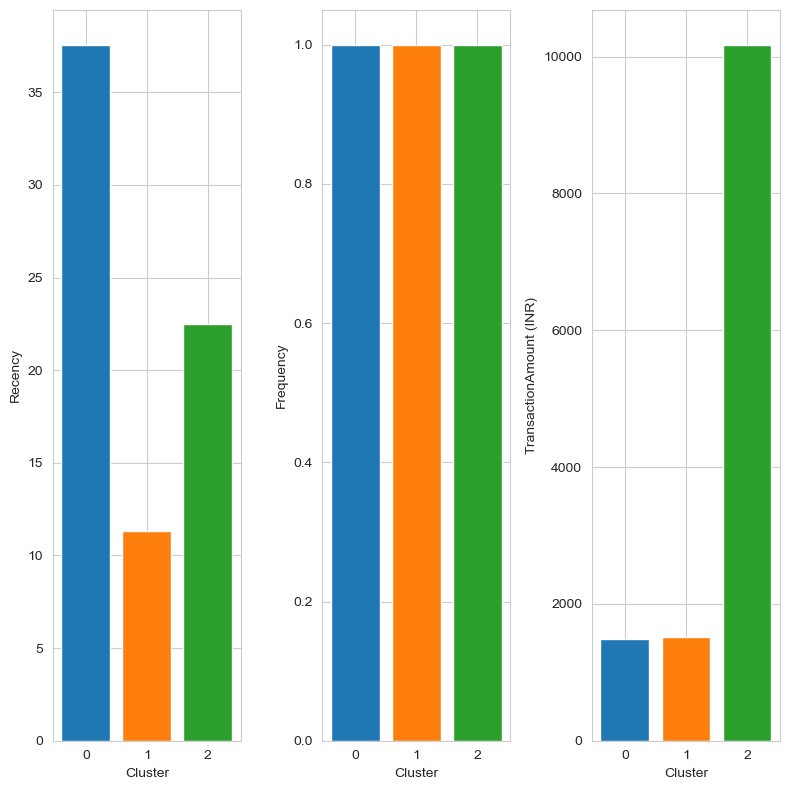

In [59]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8))
ax1.bar(x=avg_df['cluster'],height=avg_df['Recency'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Recency')
ax2.bar(x=avg_df['cluster'],height=avg_df['Frequency'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Frequency')
ax3.bar(x=avg_df['cluster'],height=avg_df['TransactionAmount (INR)'],color=['tab:blue', 'tab:orange', 'tab:green'])
ax3.set_xlabel('Cluster')
ax3.set_ylabel('TransactionAmount (INR)')
fig.tight_layout();

| Cluster | Customer Atributes | 
|:--------:|:--------:|
|  0   |  Customers in this cluster have high recency and frequency, and low transaction amount scores. These are people who frequently make small transactions.   |
|  1   |  Customers in this cluster have low recency, high frequency, and low transaction amount scores. These are people who frequently make small transactions. However, the transactions made from these customers were made earlier compared to the transactions made from customers in the other clusters.   |
|  2   |  Customers in this cluster have high recency, frequency, and transaction amount scores. These are people who frequently make large transactions.   |